In [1]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Latex, HTML
from IPython import display 

from sympy.solvers import solve
from sympy import Symbol

## Δεδομένα διατομής δοκού

In [2]:
# Σκυρόδεμα
fc = 20000.0          # KPa
Ec = 30000000.0       # KPa

# Χάλυβας διαμήκους οπλισμού
fy = 575000.0         # KPa
Es = 200000000.0      # KPa

# Χάλυβας εγκάρσιου οπλισμού
fyw = 575000.0        # KPa
Esw = 200000000.0     # KPa

b = 0.25              # Πάχος (m)
h = 0.70              # Ύψος δοκού (m)
d1 = 0.05            # "Επικάλυψη" εφεκλυόμενου οπλισμού (m)
d2 = 0.048            # "Επικάλυψη" θλιβόμενου οπλισμού (m)
As1 = 10.18           # Εμβαδό εφεκλυόμενου οπλισμού (cm2). Στον ΚΑΝ.ΕΠΕ. As
As2 = 4.62            # Εμβαδό θλιβόμενου οπλισμού (cm2). Στον ΚΑΝ.ΕΠΕ. As'
Asv = 0               # Εμβαδό ενδιάμεσου οπλισμού (cm2)
Asw = 1.01            # Εμβαδό εγκάρσιου οπλισμού (cm2)
s = 0.160              # Απόσταση μεταξύ των συνδετήρων (m)  
db = 0.018            # Διάμετρος διαμήκων ράβδων (m)
dw = 0.008            # Διάμετρος συνδετήρων (m)

N = 0.0               # Αξονικό φορτίο

Ls = 1.75

## Λύση

### Βοηθητικές συναρτήσεις

In [3]:
# Ποσοστά οπλισμού
def ρ_calc(A, b, d):
    return A/(b*d)


# Μηχανικά ποσοστά οπλισμού
def ω_calc(A, b, d, fy, fc):
    return A/(b*d)*(fy/fc)


# Υπολογισμός σημείου διαρροής
# --------------------------------------------
# Ανηγμένο ύψος θλιβόμενης ζώνης
def ξy(α, A, B):
    return math.pow((math.pow(α, 2) * math.pow(A, 2) + 2 * α * B), 0.5) - α * A

# --------------------------------------------
# Διαρροή λόγω χάλυβα
def A_steel(ρ1, ρ2, ρv, N, b, d, fy):
    return ρ1+ρ2+ρv+N/(b*d*fy)


def B_steel(ρ1, ρ2, ρv, N, b, d, δ_ton, fy):
    return ρ1 + ρ2 * δ_ton + 0.5 * ρv * (1 + δ_ton) + N / (b * d* fy)


def φy_steel(fy, Es, ξy, d):
    return fy/(Es*(1.0-ξy)*d)


# --------------------------------------------
# Διαρροή λόγω σκυροδέματος
def A_conc(ρ1, ρ2, ρv, N, b, d, α, fc):
    return ρ1 + ρ2 + ρv - N / (1.8 * α * b * d * fc)


def B_conc(ρ1, ρ2, ρv, N, b, d, δ_ton):
    return ρ1 + ρ2 * δ_ton + 0.5 * ρv * (1 + δ_ton)


def φy_conc(fc, Ec, ξy, d):
    return 1.8*fc/(Ec*ξy*d)


# --------------------------------------------
# Ροπή διαρροής My
def Mycalc(b, d, φy, Ec, ξy, δtonos, ρ1, ρ2, ρv, Es):
    return b*math.pow(d, 3)*φy*(0.5*Ec*math.pow(ξy, 2)*(0.5*(1+δtonos)-ξy/3)+((1-ξy)*ρ1+(ξy-δtonos)* ρ2+ρv*(1-δtonos)/6)*(1-δtonos)*Es/2)  


# Στροφή διαρροής θy
# (fy και fc σε MPa)
def θycalc(φy, Ls, av, z, h, db, fy, fc):
    return φy*(Ls+av*z)/3+0.0014*(1+1.5*h/Ls)+φy*db*fy /(8*math.pow(fc,0.5))


# Τέμνουσα που αντιστοιχεί σε λογή ρηγμάτωση. Χρησιμοποιείται το VRdc από EC2
def VRdc(b, d, h, ρ1, γc, fc, N):
    CRdc = 0.18/γc
    k = min(2,1 + math.pow(200/(d), 0.5))
    ρl = min(0.02, ρ1)
    k1 = 0.15
    σcp = N/(b * h)
    vmin=0.035*math.pow(k,1.5)*math.pow(fc,0.5)
    VRdc1 = (CRdc*k*math.pow((100*ρl*fc),(1/3))+k1*σcp)*b*d
    VRdc2 = (vmin+k1*σcp)*b*d
    return max(VRdc1, VRdc2)


# Τέμνουσα αντοχής
def VRcalc(h, x, Ls , N, Ac, fc, μθpl, ρtot, αs, Vw):
    # Η σχέση θέλει MN και m. Αποτέλεσμα σε MN
    # Θετική η θλίψη, 0 ο εφελκυσμός
    if N < 0: N = 0
    part1 = ((h-x)/(2*Ls))*min(N, 0.55*Ac*fc)
    part2 = 1-0.05*min(5, μθpl)
    part3 = 0.16*max(0.5, 100*ρtot)*(1-0.16*min(5,αs))*math.pow(fc, 0.5)*Ac + Vw
    return part1 + part2 * part3


# Τέμνουσα που παραλαμβάνουν οι συνδετήρες
def Vwcalc(ρw, bw, z, fyw):
    return ρw * bw * z * fyw


# Στροφή αστοχίας
def θumcalc(ν, ω1, ω2, αs, α, ρs, ρd, fc, fyw):
    part1=math.pow((fc * max(0.01, ω2) / max(0.01, ω1)), 0.225)
    part2=math.pow(αs, 0.35)
    part3=math.pow(25.0, (α * ρs * fyw / fc))
    part4=math.pow(1.25, (100 * ρd))
    
    return 0.016 * math.pow(0.3, ν) * part1 * part2 * part3 * part4

### Βοηθητικά στοιχεία της διατομής

In [4]:
# Στατικό ύψος
d = h - d1

# δ'
δtonos = d2/d

# Μοχλοβραχίονας εσωτερικών δυνάμεων
z = d-d2

# Λόγος διάτμησης
αs = Ls / h

# Ποσοστά διαμήκους οπλισμού
ρ1 = ρ_calc(As1, (b * 100), (d * 100))      # Στον ΚΑΝ.ΕΠΕ. ρ
ρ2 = ρ_calc(As2, (b * 100), (d * 100))      # Στον ΚΑΝ.ΕΠΕ. ρ'
ρv = ρ_calc(Asv, (b * 100), (d * 100)) 
ρtot = ρ1 + ρ2 + ρv

# Ποσοστό εγκάρσιου οπλισμού
ρw=ρ_calc(Asw, (b*100), (s*100)) 

# Μηχανικά ποσοστά οπλισμού
ω1 = ω_calc(As1+Asv, (b*100), (d*100), fy, fc)      # Στον ΚΑΝ.ΕΠΕ. ω
ω2 = ω_calc(As2, (b*100), (d*100), fy, fc)      # Στον ΚΑΝ.ΕΠΕ. ω'
ωtot = ω1 + ω2

print("d=" + "{0:.3f}".format(d) + "m") 

print("δ'=" + "{0:.3f}".format(δtonos))
print("z=" + "{0:.3f}".format(z) + "m") 

print("αs=" + "{0:.2f}".format(αs)) 

print("ρ1=" + "{0:.5f}".format(ρ1)) 
print("ρ2=" + "{0:.5f}".format(ρ2)) 
print("ρv=" + "{0:.5f}".format(ρv)) 
print("ρtot=" + "{0:.5f}".format(ρtot)) 

print("ρw=" + "{0:.5f}".format(ρw)) 


print("ω1=" + "{0:.3f}".format(ω1)) 
print("ω2=" + "{0:.3f}".format(ω2)) 
print("ωtot=" + "{0:.3f}".format(ωtot)) 


sh=s-dw
bc=b-2*d1              # Να τα κάνω με λίγη καλύτερη ακρίβεια
hc=h-d1-d2             # Να τα κάνω με λίγη καλύτερη ακρίβεια

ν=N/(b*h*fc)

d=0.650m
δ'=0.074
z=0.602m
αs=2.50
ρ1=0.00626
ρ2=0.00284
ρv=0.00000
ρtot=0.00911
ρw=0.00252
ω1=0.180
ω2=0.082
ωtot=0.262


In [5]:
Latex("$d = h - d_1 = {0:.3f}m - {1:.3f}m = {2:.3f}m".format(h, d1, d) + "$")

<IPython.core.display.Latex object>

In [6]:
# Latex("$δ' = d_2 / d = {0:.3f}m / {1:.3f}m = {2:.3f}".format(d2, d, δtonos) + "$")
Latex("$δ' = \dfrac{d_2}{d} = \dfrac{%.3fm}{%.3fm} = %.3f" % (d2, d, δtonos) + "$")

<IPython.core.display.Latex object>

### Υπολογισμός καμπυλότητας διαρροής

Αν η διαρροή διατοµής οφείλεται σε διαρροή του εφελκυόµενου οπλισµού, τότε:

$φ_y=\dfrac{f_y}{E_s(1-ξ_y)d}$

Αν η διαρροή διατοµής οφείλεται σε µή-γραµµικότητα των παραµορφώσεων του θλιβόµενου σκυροδέµατος (για παραµόρφωση ακραίας θλιβόµενης ίνας πέραν του $ε_c≈1.8f_c/E_c$), τότε:

$φ_y=\dfrac{ε_c}{ξ_y d}≈\dfrac{1.8 f_y}{E_s ξ_y d}$ 

Λαµβάνεται η µικρότερη των τιµών $φ_y$ 

Το ύψος της θλιβόµενης ζώνης στη διαρροή, ξy, ανηγµένο στο στατικό ύψος d, είναι:

$ξ_y=(α^2A^2+2αB)^{0.5}-αA$

όπου $α=\frac{E_s}{E_c}$ και τα A, B προσδιορίζονται από τις παρακάτω εξισώσεις, εάν η διαρροή ελέγχεται από τον εφελκυόµενο οπλισµό ή από το θλιβόµενο σκυρόδεµα, αντίστοιχα:

- ∆ιαρροή λόγω χάλυβα:

$A=ρ+ρ'+ρ_v+\dfrac{N}{bdf_y}$

$B=ρ+ρ'δ'+0.5ρ_v(1+δ')+\dfrac{N}{bdf_y}$

- ∆ιαρροή λόγω παραµορφώσεων σκυροδέµατος:

$A=ρ+ρ'+ρ_v-\dfrac{N}{ε_c E_s bd}≈ρ+ρ'+ρ_v-\dfrac{N}{1.8αbdf_c}$

$B=ρ+ρ'δ'+0.5ρ_v(1+δ')$

Στις σχέσεις αυτές ρ, ρ' και ρv είναι τα ποσοστά του εφελκυόµενου, του θλιβόµενου και του µεταξύ τους κατανεµηµένου οπλισµού (ανηγµένα στο bd), δ'=d'/d, όπου d' η απόσταση από το κέντρο του θλιβόµενου οπλισµού µέχρι την ακραία θλιβόµενη ίνα σκυροδέµατος, b το πλάτος της θλιβόµενης ζώνης και N το αξονικό φορτίο (θετικό σε θλίψη).

In [7]:
α = Es/Ec

Asteel = A_steel(ρ1, ρ2, ρv, N, b, d, fy)
Βsteel = B_steel(ρ1, ρ2, ρv, N, b, d, δtonos, fy)
ξysteel =ξy(α, Asteel, Βsteel)
φysteel = φy_steel(fy, Es, ξysteel, d)

Aconc = A_conc(ρ1, ρ2, ρv, N, b, d, α, fc)
Bconc = B_conc(ρ1, ρ2, ρv, N, b, d, δtonos)
ξyconc =ξy(α, Aconc, Bconc)
φyconc = φy_conc(fc, Ec, ξyconc, d)

print("Asteel=" + "{0:.5f}".format(Asteel)) 
print("Βsteel=" + "{0:.5f}".format(Βsteel))
print("ξysteel=" + "{0:.4f}".format(ξysteel))
print("φysteel=" + "{0:.5f}".format(φysteel))
print("Aconc=" + "{0:.5f}".format(Aconc)) 
print("Bconc=" + "{0:.5f}".format(Bconc))
print("ξyconc=" + "{0:.4f}".format(ξyconc))
print("φyconc=" + "{0:.5f}".format(φyconc))

if φysteel < φyconc:
    φy = φysteel
    ξy = ξysteel
else:
    φy = φyconc
    ξy = ξyconc

x = ξy * d

print('')
print('Τελικά')
print("φy=" + "{0:.5f}".format(φy))
print("ξy=" + "{0:.4f}".format(ξy))
print("x=" + "{0:.4f}".format(x))

Asteel=0.00911
Βsteel=0.00647
ξysteel=0.2393
φysteel=0.00581
Aconc=0.00911
Bconc=0.00647
ξyconc=0.2393
φyconc=0.00771

Τελικά
φy=0.00581
ξy=0.2393
x=0.1555


### Υπολογισμός ροπής διαρροής

Με δεδοµένη την καµπυλότητα στη διαρροή, η αντίστοιχη ροπή $Μ_y$ προκύπτει ως:

$\dfrac{M_y}{bd^3}=φ_y\Bigg\{E_c\dfrac{ξ_y^2}{2}\bigg(0.5(1+δ')-\dfrac{ξ_y}{3}\bigg) + \bigg[ (1-ξ_y)ρ+(ξ_y-δ')ρ'+\dfrac{ρ_v}{6}(1-δ') \bigg]\cdot(1-δ')\dfrac{E_s}{2} \Bigg\}$


In [8]:
My = Mycalc(b, d, φy, Ec, ξy, δtonos, ρ1, ρ2, ρv, Es)

print("My=" + "{0:.3f}".format(My))

My=350.350


### Υπολογισμός στροφής διαρροής

α) Στον υπολογισµό της παραµόρφωσης πρέπει να λαµβάνεται υπόψη η συµβολή και της κάµψης και της διάτµησης.

β) Η συµβολή της κάµψης στην παραµόρφωση διαρροής µπορεί να εκτιµηθεί µε βάση την τιµή της καµπυλότητας διαρροής, $φ_y$ , η οποία µπορεί να υπολογισθεί µε βάση την υπόθεση επιπεδότητας διατοµών και µε γραµµικό νόµο σ-ε του χάλυβα και του σκυροδέµατος σε θλίψη, για µηδενική εφελκυστική αντοχή του σκυροδέµατος.

γ) Σε περιοχές δοµικών στοιχείων όπου οι διαµήκεις οπλισµοί ενώνονται µε παράθεση των άκρων τους, η τιµή της καµπυλότητας διαρροής µπορεί να υπολογισθεί µε βάση τις υποθέσεις (i) ,(ii) και (iii) του εδ. (δ) της § 7.2.1

δ) Εάν οι παραµορφώσεις “δ” αναφέρονται στο σύνολο του µήκους $L_s=α_sh$ στο άκρο δοµικού στοιχείου (π.χ. όταν ως δ χρησιµοποιείται η γωνία στροφής χορδής θ), τότε στη φάση της καµπτικής διαρροής το τµήµα της $θ_y$ που οφείλεται στην κάµψη, µπορεί να ληφθεί ίσο µε $(1/r)_y(Ls+a_{V}z)/3$, όπου ο όρος $a_vz$ εκφράζει την επιρροή του «µήκους µετάθεσης» των ροπών κάµψης σ’ αυτές, z είναι ο µοχλοβραχίονας εσωτερικών δυνάµεων, ο δε συντελεστής $a_V$ ισούται µε 1 εάν η τέµνουσα, $V_{R1}$, που προκαλεί λοξή ρηγµάτωση του στοιχείου, υπολείπεται της τιµής της τέµνουσας κατά την καµπτική διαρροή $V_{Mu}=M_y/L_s$, και µε 0 αν είναι µεγαλύτερη. Στην τιµή αυτή χρειάζεται να προστεθεί η συµβολή της στροφής της ακραίας διατοµής λόγω εξόλκευσης του τµήµατος των ράβδων πέραν της ακραίας διατοµής του στοιχείου. Χρειάζεται επίσης να προστεθεί η συµβολή των διατµητικών παραµορφώσεων στη $θ_y$.


> Το µήκος $L_s$ είναι ο λόγος M/V στην ακραία διατοµή του στοιχείου, δηλαδή η απόσταση της ακραίας διατοµής από το σηµείο µηδενισµού των ροπών.

> Η εξόλκευση του τµήµατος των ράβδων πέραν της διατοµής στήριξης είναι ανάλογη: (i) της µήκυνσης του χάλυβα στη διαρροή, και (ii) του µήκους που απαιτείται για την αγκύρωση των ράβδων. Εάν δεν υπάρχουν ακριβέστερα στοιχεία, η γωνία στροφής χορδής $θ_y$ στην καµπτική διαρροή στοιχείων µπορεί να εκτιµηθεί από την ακόλουθη έκφραση:

> - Για δοκούς ή υποστυλώματα
$$θ_y=φ_y\dfrac{L_s+a_vz}{3}+0.0014 \Big(1+1.5\dfrac{h}{L_s} \Big)+\dfrac{φ_yd_bf_y}{8\sqrt{f_c}}$$

> - Για τοιχώματα
$$θ_y=φ_y\dfrac{L_s+a_vz}{3}+0.0013 +\dfrac{φ_yd_bf_y}{8\sqrt{f_c}}$$

> Στις Εξ. (Σ.2) και (Σ.3), ο 1ος όρος εκφράζει την συµβολή των καµπτικών παραµορφώσεων, ο 2ος όρος εκφράζει τις µέσες διατµητικές παραµορφώσεις στο µήκος Ls, ενώ ο 3ος όρος εκφράζει την επιρροή της εξόλκευσης του τµήµατος των ράβδων πέραν της ακραίας διατοµής του στοιχείου ($f_y$ και $f_c$ σε MPa)

ε) Εάν οι εφελκυόµενοι διαµήκεις οπλισµοί επεκτείνονται πέραν της ακραίας διατοµής απλώς για αγκύρωση κατά το εδ. (ε) της §7.2.1, σε µήκος το οποίο δεν είναι επαρκές για την ανάπτυξη της πλήρους ροπής διαρροής (ή αστοχίας) Μy, στην ακραία διατοµή κατά το εδ. (ε) της § 7.2.1, τότε χρειάζεται να ληφθεί υπόψη η επιρροή της ελλειπούς αγκύρωσης των εφελκυοµένων ράβδων στην παραµόρφωση διαρροής του στοιχείου.

στ) Αν η τέµνουσα αντοχής του στοιχείου, $V_R$, υπολείπεται της τιµής της τέµνουσας κατά την καµπτική διαρροή, $V_{Mu}=M_y/L_s$, τότε καθοριστική της διαρροής είναι η διάτµηση, οπότε η παραµόρφωση διαρροής υπολογίζεται ως το γινόµενο της $φ_y$ ή της $θ_y$ επί $V_RL_s/M_y$, ανάλογα µε το νόηµα της δ (ως φ ή ως θ)

- Υπολογισμός V<sub>R</sub> 

$V_R=\dfrac{h-x}{2L_s}\cdot min(N,0.55\cdot A_c \cdot f_c)+ \big(1-0.05\cdot min(5, µ_θ^{pl}) \big)\Big[0.16 \cdot max(0.5,100ρ_{tot}) \big(1-0.16 \cdot min(5,a_s) \big)\cdot \sqrt{f_c} \cdot A_c + V_w \Big]$

In [9]:
VMu = My/Ls
VR1 = VRdc(b*1000, d*1000, h*1000, ρ1, 1.0, fc/1000, N)/1000

if VR1 < VMu:
    av=1.0
else:
    av=0.0

# Αρχική τιμή θy. Χωρίς τον έλεγχο με τις τέμνουσες
θy = θycalc(φy, Ls, av, z, h, db, fy/1000, fc/1000)

Vw = Vwcalc(ρw, b, z, fyw)

VR0 = VRcalc(h, x, Ls , N/1000, b*d, fc/1000, 0, ρtot, αs, Vw/1000)*1000

print("VMu=" + "{0:.3f}".format(VMu) + "kN")
print("VR1=" + "{0:.3f}".format(VR1) + "kN")
print("av=" + "{0:.1f}".format(av))
print("θy=" + "{0:.4f}".format(θy) + " Αρχική τιμή θy. Χωρίς τον έλεγχο με τις τέμνουσες")

print("Vw=" + "{0:.3f}".format(Vw) + "kN")
print("VR0=" + "{0:.3f}".format(VR0) + "kN")

VMu=200.200kN
VR1=105.620kN
av=1.0
θy=0.0085 Αρχική τιμή θy. Χωρίς τον έλεγχο με τις τέμνουσες
Vw=218.507kN
VR0=282.047kN


Text(0.5,1,'VR vs plastic ductility')

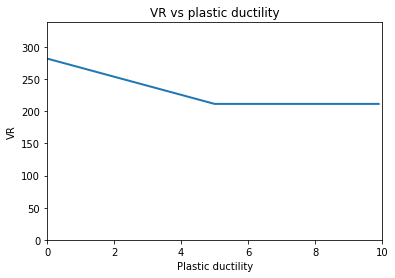

In [10]:
xs=list()
ys=list()

for i in range(0, 100):
    xs.append(0.1 * i)
    ys.append(VRcalc(h, x, Ls , N/1000, b*d, fc/1000, 0.1*i, ρtot, αs, Vw/1000)*1000)

    
plt.plot(xs, ys, lw=2)
plt.axis([0, 10, 0, 1.2*VR0])
plt.ylabel('VR') 
plt.xlabel('Plastic ductility') #'μθpl'  
plt.title('VR vs plastic ductility')

Text(0.5,1,'VR vs λ*θy')

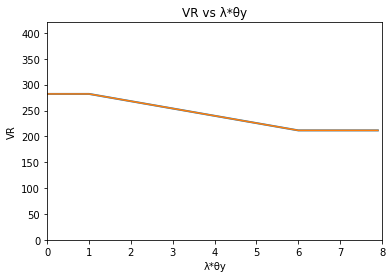

In [11]:
xs=list()
ys=list()

for i in range(0, 80):
    xs.append(0.1 * i)
    μθpl=max(0, 0.1*i-1)
    ys.append(VRcalc(h, x, Ls , N/1000, b*d, fc/1000, μθpl, ρtot, αs, Vw/1000)*1000)

    
plt.plot(xs, ys, lw=2)
plt.axis([0, 8, 0, 1.2* My])
plt.plot(xs, ys)
plt.ylabel('VR') 
plt.xlabel('λ*θy')   
plt.title('VR vs λ*θy')

Text(0.5,1,'M(VR) vs λ*θy')

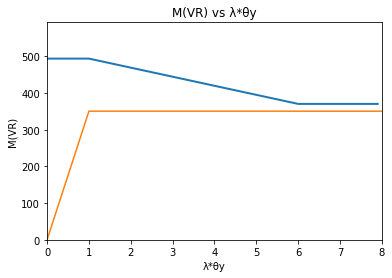

In [12]:
xs=list()
ys=list()

for i in range(0, 80):
    xs.append(0.1 * i)
    μθpl=max(0, 0.1*i-1)
    VRi=VRcalc(h, x, Ls , N/1000, b*d, fc/1000, μθpl, ρtot, αs, Vw/1000)*1000
    ys.append(VRi*Ls)

x2s=[0, 1, 8]
y2s=[0, My, My]


    
plt.plot(xs, ys, lw=2)
plt.axis([0, 8, 0, 1.2*max(VR0*Ls, My)])
plt.plot(x2s, y2s)
plt.ylabel('M(VR)') 
plt.xlabel('λ*θy')   
plt.title('M(VR) vs λ*θy')

### Τελικές τιμές στο σημείο διαρροής

In [13]:
if My<VR0*Ls:
    ShearStatus='Δεν υπάρχει αστοχία από τέμνουσα πριν την καμπτική διαρροή'

else:
    ShearStatus='ΠΡΟΣΟΧΗ: Υπάρχει αστοχία από τέμνουσα πριν την καμπτική διαρροή'
    φy = φy * VR0 * Ls / My
    θy = θy * VR0 * Ls / My
    My = VR0 * Ls

print(ShearStatus)
    
print("My=" + "{0:.3f}".format(My))
print("φy=" + "{0:.6f}".format(φy))
print("θy=" + "{0:.4f}".format(θy))

Δεν υπάρχει αστοχία από τέμνουσα πριν την καμπτική διαρροή
My=350.350
φy=0.005815
θy=0.0085


### Ενεργός δυσκαμψίς. Συντελεστής για SAP

In [14]:
K = My * Ls / (3 * θy)
print("K=" + "{0:.4f}".format(K))

K=24098.3852


In [15]:
I = b * math.pow(h , 3) / 12.0
K0 = Ec * I

ModFactor = K / K0

print("Modification Factor for SAP=" + "{0:.4f}".format(ModFactor))

Modification Factor for SAP=0.1124


### Στροφή αστοχίας

#### - Υπολογισμός θ<sub>um</sub> 

$θ_{um}=0.016\cdot(0.3^ν)\Bigg[\dfrac{max(0.01,ω')}{max(0.01,ω)} \Bigg]^{0.225}\cdot (α_s)^{0.35} \cdot 25^{\bigg(α\cdot ρ_s \cdot \dfrac{f_{yw}}{f_c} \bigg)}\cdot (1.25^{100ρ_d})$

όπου:

- $α_s$ ο λόγος διάτμησης

- $ω$, $ω'$ µηχανικό ποσοστό εφελκυόµενου και θλιβόµενου οπλισµού (ο ενδιάµεσος διαµήκης οπλισµός µεταξύ εφελκυοµένου και θλιβόµενου πέλµατος θεωρείται ως εφελκυόµενος)

- $ν=\dfrac{N}{bhf_c}=0$ 

- $ρ_s=\dfrac{A_{sh}}{b\cdot s_h}$ Το γεωµετρικό ποσοστό εγκάρσιου οπλισµού παράλληλα στη διεύθυνση της φόρτισης

- $s_h=s-d_w$  Η καθαρή απόσταση των συνδετήρων

- $ρ_d=0$  Το γεωµετρικό ποσοστό του δισδιαγώνιου οπλισµού

- $α=\Big( 1-\dfrac{s_h}{2\cdot b_c} \Big)\Big( 1-\dfrac{s_h}{2\cdot h_c} \Big)\Big( 1-\dfrac{\sum b_i^2}{6\cdot b_c \cdot h_c} \Big)$

Στη σχέση του $α$ οι $b_c$ και $h_c$ είναι οι διαστάσεις του πυρήνα (µε $h_c<1.5÷2.0b_c$) και $b_i$ οι (περίπου ίσες) αποστάσεις
µεταξύ διαµήκων ράβδων που συγκρατούνται από συνδετήρα ή άγκιστρο σιγµοειδούς εγκάρσιου συνδέσµου, κατά την περίµετρο της διατοµής. Εναλλακτικώς, µπορεί να χρησιµοποιηθεί αντί του $h_c$ το ύψος της θλιβόµενης ζώνης εντός του περισφιγµένου πυρήνα,
οπότε ως bi θα λαµβάνονται οι αποστάσεις µεταξύ διαµήκων ράβδων κατά την εξωτερική περίµετρο της θλιβόµενης ζώνης, µε αφετηρία τον ουδέτερο άξονα.  
$b_c=b-2\cdot d_1$  
$h_c=h-d_1-d_2$

In [16]:
hctmp=hc

if (hc>1.75*bc): hctmp=x-d2

print("sh=" + "{0:.4f}".format(sh)+"")
print("bc=" + "{0:.4f}".format(bc)+"")
print("hctmp=" + "{0:.4f}".format(hctmp)+"")
        
Σbi2=2*math.pow(bc,2)+2*math.pow(hctmp,2)   # για 2τμητους μονούς συνδετήρες...περίπου
print("Σbi2=" + "{0:.5f}".format(Σbi2)+"")
        
αper=(1-sh/(2*bc))*(1-sh/(2*hctmp))*(1-Σbi2/(6*bc*hctmp))   
        
print("Συντελεστής αποδοτικότητας α=" + "{0:.4f}".format(αper)+"")

sh=0.1520
bc=0.1500
hctmp=0.1075
Σbi2=0.06813
Συντελεστής αποδοτικότητας α=0.0429


In [17]:
θum=θumcalc(ν, ω1, ω2, αs, αper, ρw, 0.0, fc/1000, fyw/1000)

print("θum=" + "{0:.4f}".format(θum))


θum=0.0366


In [18]:
μθ = θum / θy
μθπλ = μθ -1

VRμθπλ=VRcalc(h, x, Ls , N/1000, b*d, fc/1000, μθpl, ρtot, αs, Vw/1000)*1000

print("μθ=" + "{0:.3f}".format(μθ))
print("μθπλ=" + "{0:.3f}".format(μθπλ))

print("VRμθπλ=" + "{0:.3f}".format(VRμθπλ))

μθ=4.314
μθπλ=3.314
VRμθπλ=211.535


In [19]:
υ = Symbol('υ')
μθV=solve((((h-x)/(2*Ls))*min(N/1000, 0.55*b*d*fc/1000) + (1-0.05*υ) * (0.16*max(0.5, 100*ρtot)*(1-0.16*min(5,αs))*math.pow(fc/1000, 0.5)*b*d + Vw/1000)*1000-My/Ls),υ)[0]

print(μθV)

5.80380799185999


In [20]:
if μθV<5 and μθV<μθπλ and μθπλ>0:
    μθπλ = μθV
    ShearStatus='ΠΡΟΣΟΧΗ: Υπάρχει αστοχία από τέμνουσα μετά την καμπτική διαρροή'
    θum=θy*(1.0+μθV)
    print(ShearStatus)
    print(μθV)

Text(0.5,1,'M vs θ')

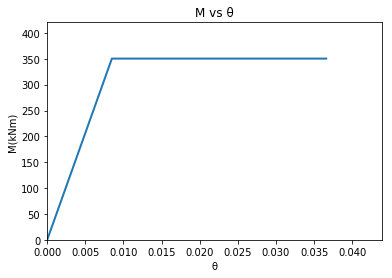

In [21]:
xs=[0, θy, θum]
ys=[0, My, My]

    
plt.plot(xs, ys, lw=2)
plt.axis([0, 1.2*θum, 0, 1.2*My])
plt.ylabel('M(kNm)') 
plt.xlabel('θ')   
plt.title('M vs θ')